**Introduction**  
The goal of this notebook and challenge is to create an algorithm that identifies metastatic cancer in small image patches taken from a larger scan. There are 220025 annotated image patches, 89,117 of them are postive sample 130,908 are negative. Each sample in the dataset has an image id and a binary label for positive or negative and every image is a fixed size. Below you'll see a print out of the information, a histogram of the data samples and a sample image.. 

In [ ]:
!pip install tensorflow

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Dataset size: 220025
Number of positive samples (cancer detected): 89117
Number of negative samples (no cancer): 130908
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


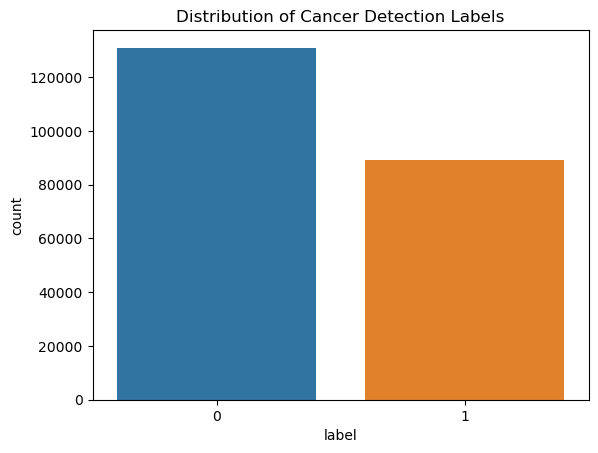

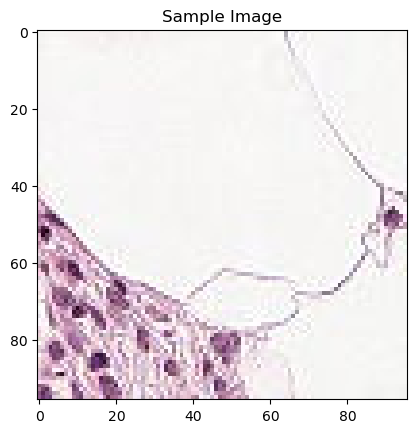

In [3]:
image_dir = 'Data/train_cancer/'
labels_path = 'Data/train_cancer_labels.csv'

labels_df = pd.read_csv(labels_path)

print("Dataset size:", len(labels_df))
print("Number of positive samples (cancer detected):", labels_df['label'].sum())
print("Number of negative samples (no cancer):", len(labels_df) - labels_df['label'].sum())

print(labels_df.head())

sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Cancer Detection Labels')
plt.show()

sample_image_path = image_dir + labels_df.iloc[0]['id'] + '.tif'
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.title('Sample Image')
plt.show()

**Exploratory Data Analysis (EDA)**  
Data cleaning procedures:  
We can check for image file corruption. We can also normalize the image from being on a 0 to 255 scale to being on a 0 to 1.  
Visualizations:  
Below is shown 10 different samples of data, on the x-axis is the range of pixel values 0 to 255 on how dark to light the pixels are and the y-axis is the number of pixels in that image in each bin.  
The blue are negative samples, red being positive.  
Based on the information we have, it doesn't look like looking at how intense the images are with the light values may be successful. So going forward an approach based off of different patches in the model or looking at color channels will be what we do going forward into building the model. Starting with a simple baseline CNN model with which we will hyperparameter tune and iterate upon.

In [4]:
#Data Cleaning Methods
def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return False
    except (IOError, SyntaxError) as e:
        return True

def normalize_image(image_array):
    return image_array / 255.0

#Loading Data
sample_size = 10000
sampled_labels_df = labels_df.sample(n=sample_size, random_state=1)
images = []
labels = []
for _, row in sampled_labels_df.iterrows():
    image_path = os.path.join(image_dir, row['id'] + '.tif')
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    images.append(image_array)
    labels.append(row['label'])

images = np.array(images)
labels = np.array(labels)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=1, stratify=labels
)

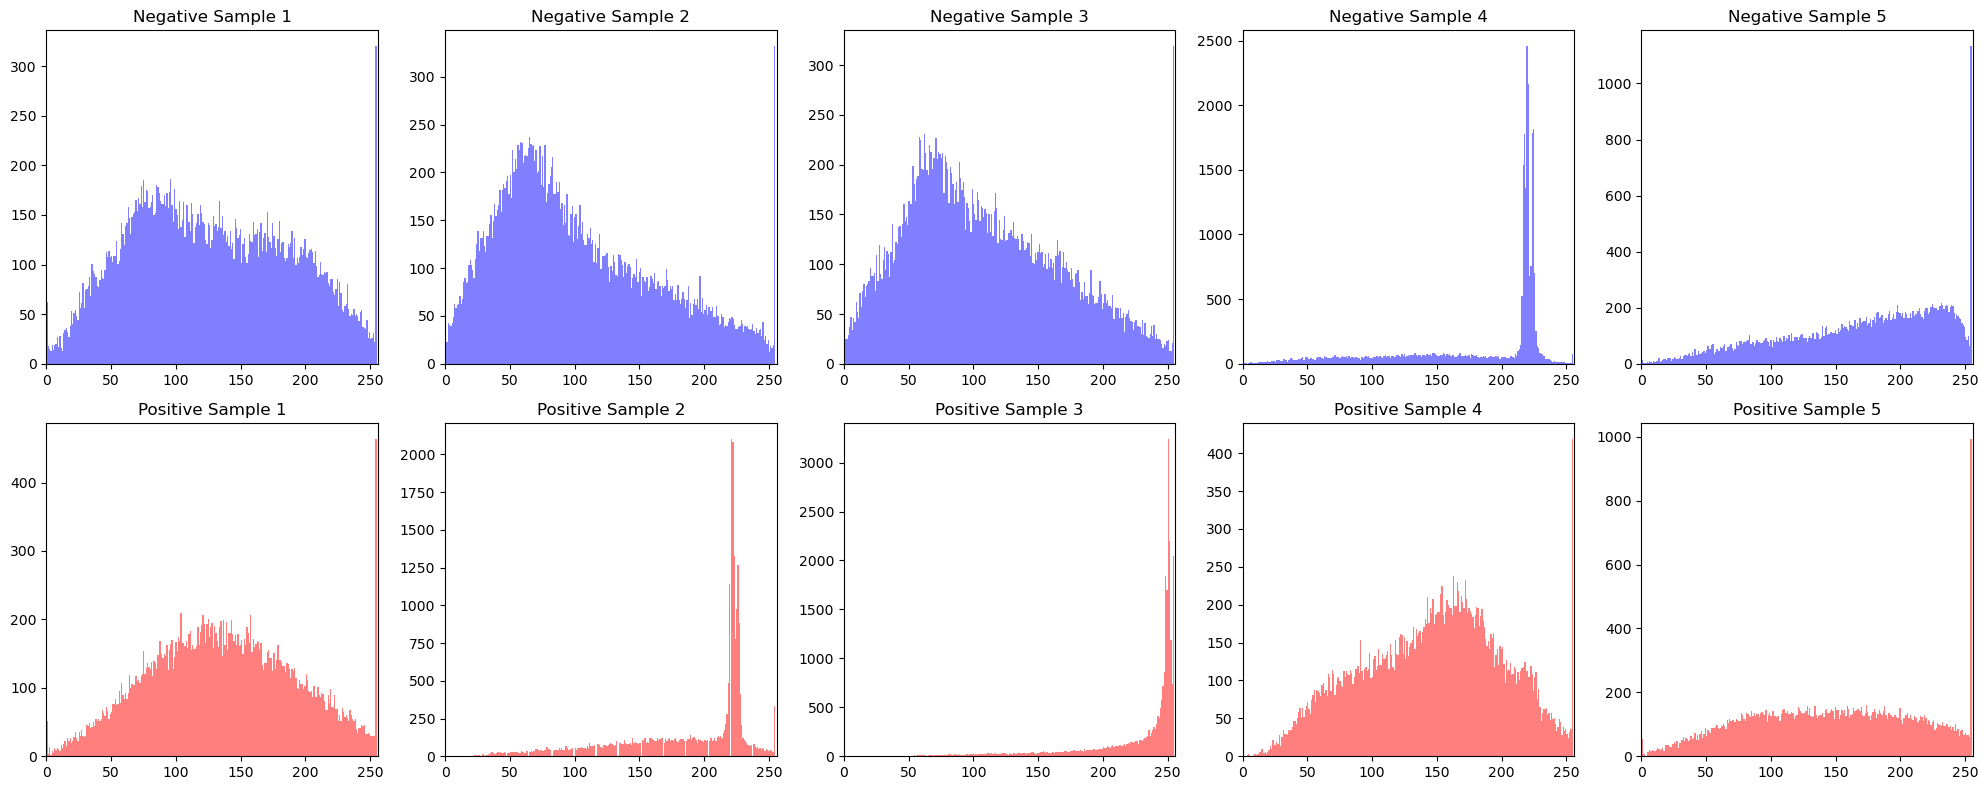

In [5]:
#Visualizations
negative_samples = labels_df[labels_df['label'] == 0].sample(n=5, random_state=1)
positive_samples = labels_df[labels_df['label'] == 1].sample(n=5, random_state=1)

def read_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, (idx, row) in enumerate(negative_samples.iterrows()):
    image_path = os.path.join(image_dir, row['id'] + '.tif')
    image = read_image(image_path)
    axes[0, i].hist(image.ravel(), bins=256, color='blue', alpha=0.5)
    axes[0, i].set_title(f'Negative Sample {i+1}')
    axes[0, i].set_xlim([0, 256])

for i, (idx, row) in enumerate(positive_samples.iterrows()):
    image_path = os.path.join(image_dir, row['id'] + '.tif')
    image = read_image(image_path)
    axes[1, i].hist(image.ravel(), bins=256, color='red', alpha=0.5)
    axes[1, i].set_title(f'Positive Sample {i+1}')
    axes[1, i].set_xlim([0, 256])

plt.tight_layout()
plt.show()

**Model Architecture**  
This model uses convolution layers followed by max-pooling layers in order to extract features from the images, from the EDA we know that there most likely won't be any success through trying to look at light levels in the image. The goal here is now to get shapes, patterns, edges, textures, etc.. and using convolution layers will abstract those as we go deeper in the network. The pooling layers are meant to reduce the dimensionality of the features map. Then the dropout is meant to prevent the model becoming too dependent on any individual nodes. The final dense layer is to perform the classification.

In [6]:
#Defining model and performing hyperparameter tuning
def build_model(learning_rate=0.0001, dense_neurons=256):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_neurons, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

hyperparameters_sets = [
    {'learning_rate': 0.001, 'dense_neurons': 512, 'batch_size': 32},
    {'learning_rate': 0.0001, 'dense_neurons': 512, 'batch_size': 64},
    {'learning_rate': 0.001, 'dense_neurons': 256, 'batch_size': 32},
    {'learning_rate': 0.0001, 'dense_neurons': 256, 'batch_size': 64}
]

for params in hyperparameters_sets:
    model = build_model(learning_rate=params['learning_rate'], dense_neurons=params['dense_neurons'])
    print(f"Testing model with learning rate {params['learning_rate']} and dense neurons {params['dense_neurons']}")
    model.fit(train_images, train_labels, epochs=10, batch_size=params['batch_size'], validation_data=(val_images, val_labels))
    print("\n\n")

**Results and Analysis**  
Hyperparameter tuning results
| Configuration | Validation Accuracy |
|:--------------|:-------------------:|
| Baseline, LR=0.001, Neurons=512, Batch=32 | 0.596 |
| Exp 2, LR=0.0001, Neurons=512, Batch=64 | 0.7945 |
| Exp 3, LR=0.001, Neurons=256, Batch=32 | 0.596 |
| Exp 4, LR=0.0001, Neurons=256, Batch=64 | 0.7985 |

Through hyperparameter tuning a lower learning rate seemed to generally provide better validation accuracy and the number of neurons (256 vs 512) did not impact perfomance significantly. The best performing models used learning rate = 0.0001. Through this what experiment what worked well was lowering learning rate combined with higher batch size. In addition the dropout before the final dense layer mitigated potential overfitting.

**Conclusion**  
The main takeaway for this work is that model development is iterative and requires continuous experimentation and validation. There was a clear direction from the beginning to use a CNN model and from the experimentation with hyperparameter optimization is very vital going from a baseline of 0.596 to 0.7985 validation accuracy. In the future testing with techniques like learning transfer and also making more architectural changes could be a good addition.